# State machines

The guards are simple state machines.

* There are 60 points in time for each date they are on duty
* The event log record state changes
* We simply need to translate the state changes to states per minute in the midnight hour for every day

In [1]:
import enum
import re
from datetime import date, datetime, timedelta
from itertools import repeat
from operator import attrgetter, itemgetter
from typing import Dict, Iterable, Iterator, List, Optional, Sequence, Tuple

GuardID = int
Minute = int

class State(enum.Enum):
    off_duty = "Off Duty"
    awake = "Awake"
    asleep = "Asleep"

class Transition(enum.Enum):
    started_duty = "begins shift", State.off_duty, State.awake
    wake = "wakes up", State.asleep, State.awake
    sleep = "falls asleep", State.awake, State.asleep
    
    def __init__(self, pattern, old, new):
        self.pattern: str = pattern
        self.old: State = old
        self.new: State = new
    
    @classmethod
    def from_line(cls, line: str) -> Tuple[datetime, 'Transition', Optional[GuardID]]:
        """Produce a (datetime, transition, guardid) tuple
        
        The guard information is only available for 'begins shift' entries.
        
        """
        match = _parse_line(line).groupdict()
        assert match['guard'] if match['transition'] == 'begins shift' else match['guard'] is None
        dt = datetime.strptime(match['timestamp'], "%Y-%m-%d %H:%M")
        guard = int(match['guard']) if match['transition'] == 'begins shift' else None
        return (dt, next(t for t in cls if t.pattern == match['transition']), guard)

_parse_line = re.compile(
    r"\[(?P<timestamp>[^\]]+)\]\s+"
    r"(?:Guard\s+#(?P<guard>\d+)\s+)?"
    r"(?P<transition>{})".format(
        '|'.join([re.escape(t.pattern) for t in Transition])
    )
).search


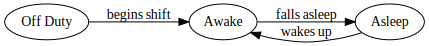

In [2]:
import graphviz
dot = graphviz.Digraph('state_machine', graph_attr={'rankdir': 'LR'}, strict=True)
for state in State:
    dot.node(state.name, state.value)
for trans in Transition:
    dot.edge(trans.old.name, trans.new.name, label=trans.pattern)
dot

In [3]:
_minute_header_lines: Tuple[str] = (
    ''.join([c * 10 for c in "012345"]),
    ''.join(["0123456789" * 6])
)

class Guard:
    def __init__(self, id: GuardID) -> None:
        self.id = id
        self._events: List[Transition] = []
        # for each date, there are 60 states, one for each minute in the midnight hour
        self._by_date: Dict[date, Sequence[State]] = {}

    def add_events(self, *events: Tuple[datetime, Transition]):
        self._events.extend(events)
        self._by_date.clear()
        
    def _build_states(self):
        if self._by_date:
            return
        for dt, transition in sorted(self._events):
            assert dt.hour == 0 if transition is not Transition.started_duty else True
            d, minute = dt.date(), dt.minute
            if transition is Transition.started_duty and dt.hour:
                # move the state change to first minute of midnight
                d += timedelta(days=1)
                minute = 0
            if d not in self._by_date:
                self._by_date[d] = [State.off_duty] * 60
            states = self._by_date[d]
            assert states[minute] is transition.old
            while minute < 60 and states[minute] is transition.old:
                states[minute] = transition.new
                minute += 1

    def by_minute(self) -> Iterator[Tuple[Minute, Sequence[State]]]:
        """Iterator with (date, states) entries by minute"""
        self._build_states()
        return enumerate(zip(*map(
            itemgetter(1), sorted(self._by_date.items(), key=itemgetter(0))
        )))
        
    def __iter__(self) -> Iterator[Tuple[date, Sequence[State]]]:
        """Iterate over (date, state) entries, ordered by date"""
        self._build_states()
        return iter(sorted(self._by_date.items()))
    
    def __repr__(self):
        return f"Guard({self.id})"
    
    def __str__(self):
        self._build_states()
        header = (
            f"Guard #{self.id}\n"
            f"Date   Minute\n"
            f"       {_minute_header_lines[0]}\n"
            f"       {_minute_header_lines[1]}\n"
            "\n"
        )
        state_map = {State.off_duty: ' ', State.awake: '.', State.asleep: '#'}
        lines = '\n'.join([
            f"{d:%m-%d}  {''.join(map(state_map.get, states))}"
            for d, states in self
        ])
        return f"{header}{lines}"
    
    @property
    def asleep(self) -> int:
        """Total time asleep on duty"""
        return sum(states.count(State.asleep) for _, states in self.by_minute())
    
    @property
    def minute_most_asleep(self) -> int:
        return max((states.count(State.asleep), m) for m, states in self.by_minute())[1]

def schedule_from_events(events: Iterable[str]) -> Dict[GuardID, Guard]:
    events_by_date: Dict[date, List[Tuple[date, Transition]]] = {}  # events without a guard
    guards: Dict[GuardID, Guard] = {}  # guards results
    guard_by_date: Dict[date, Guard] = {}  # date a guard is on duty, mapped to guard
    
    for line in events:
        dt, transition, id = Transition.from_line(line)
        d = dt.date()
        if dt.hour:
            # before midnight, only care about the next midnight part of the shift
            d += timedelta(days=1)
        if transition is Transition.started_duty:
            if id not in guards:
                guards[id] = Guard(id)
            guard_by_date[d] = guards[id]
            guards[id].add_events((dt, transition), *events_by_date.pop(d, ()))
        else:
            if d not in guard_by_date:
                events_by_date.setdefault(d, []).append((dt, transition))
            else:
                guard_by_date[d].add_events((dt, transition))
    
    return guards

def print_schedule(guards: Iterable[Guard]) -> None:
    by_date: Dict[date, Tuple[GuardID, str]] = {}
    header = (
        f"Date   ID     Minute\n"
        f"              {_minute_header_lines[0]}\n"
        f"              {_minute_header_lines[1]}\n"
        "\n"
    )
    state_map = {State.off_duty: ' ', State.awake: '.', State.asleep: '#'}
    for guard in guards:
        for d, states in guard:
            by_date[d] = (guard.id, ''.join(map(state_map.get, states)))
    print(header)
    for d, (id, stateline) in sorted(by_date.items()):
        print(f"{d:%m-%d}  #{id:<4d}  {stateline}")

In [4]:
testdata = """\
[1518-11-01 00:00] Guard #10 begins shift
[1518-11-01 00:05] falls asleep
[1518-11-01 00:25] wakes up
[1518-11-01 00:30] falls asleep
[1518-11-01 00:55] wakes up
[1518-11-01 23:58] Guard #99 begins shift
[1518-11-02 00:40] falls asleep
[1518-11-02 00:50] wakes up
[1518-11-03 00:05] Guard #10 begins shift
[1518-11-03 00:24] falls asleep
[1518-11-03 00:29] wakes up
[1518-11-04 00:02] Guard #99 begins shift
[1518-11-04 00:36] falls asleep
[1518-11-04 00:46] wakes up
[1518-11-05 00:03] Guard #99 begins shift
[1518-11-05 00:45] falls asleep
[1518-11-05 00:55] wakes up
""".splitlines()
testguards = schedule_from_events(testdata)
print_schedule(testguards.values())
assert testguards[10].asleep == 50, testguards[10].minute_most_asleep == 24
assert testguards[99].asleep == 30
picked_guard = max(testguards.values(), key=attrgetter("asleep"))
assert picked_guard.minute_most_asleep * picked_guard.id == 240

Date   ID     Minute
              000000000011111111112222222222333333333344444444445555555555
              012345678901234567890123456789012345678901234567890123456789


11-01  #10    .....####################.....#########################.....
11-02  #99    ........................................##########..........
11-03  #10         ...................#####...............................
11-04  #99      ..................................##########..............
11-05  #99       ..........................................##########.....


In [5]:
with open("inputs/day04.txt") as day4:
    guards = schedule_from_events(day4)

In [6]:
choice = max(guards.values(), key=attrgetter("asleep"))
print(choice)
print("Part 1:", choice.id * choice.minute_most_asleep)

Guard #1049
Date   Minute
       000000000011111111112222222222333333333344444444445555555555
       012345678901234567890123456789012345678901234567890123456789

03-22  ......###################################################...
04-01   .................................######################....
04-15  .........................#####.......##.....................
04-18  ..........###########..............#######################..
04-24    .............................##########...................
05-07  .................#####......................................
05-10  .................................#......##################..
05-12  ########################################################....
06-08      ......#########################################.....##..
06-10     .........#######################################.........
06-11   ........................###########################........
06-22  .....####################################...................
06-26  ..############